# Computational Reproducibility of Jupyter Notebooks from Pubmed Central Publications

## Programming languages of the notebooks

Analyse the metadata related to programming languages of Jupyter Notebooks mentioned in the Pubmed Central publications.

In [59]:
import sys
sys.path.insert(0, '../archaeology')
sys.path.insert(0, '../analysis')

from pathlib import Path

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from db import connect

%matplotlib inline

In [60]:
# Create folder for outputs
OUTPUT_DIR = 'Outputs'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

## Relative proportion of the most frequent programming languages used in the notebooks per year.

In [61]:
with connect() as session:
    query = (
        "select n.id, n.repository_id, n.name, n.language, rd.created_at "
        "from notebooks n, repository_data rd where n.repository_id=rd.repository_id"
    )
    df = pd.read_sql(query, session.connection())
    df['created_year'] = pd.DatetimeIndex(df['created_at']).strftime('%Y')


In [62]:
notebook_language_year_df = df[['language','created_year']].value_counts().reset_index().sort_index()
notebook_language_year_df.columns = ['language','created_year', 'notebook_count']

In [63]:
notebook_language_year_df = notebook_language_year_df[notebook_language_year_df['notebook_count'] > 7]
notebook_language_year_df['language'] = notebook_language_year_df['language'].str.capitalize()

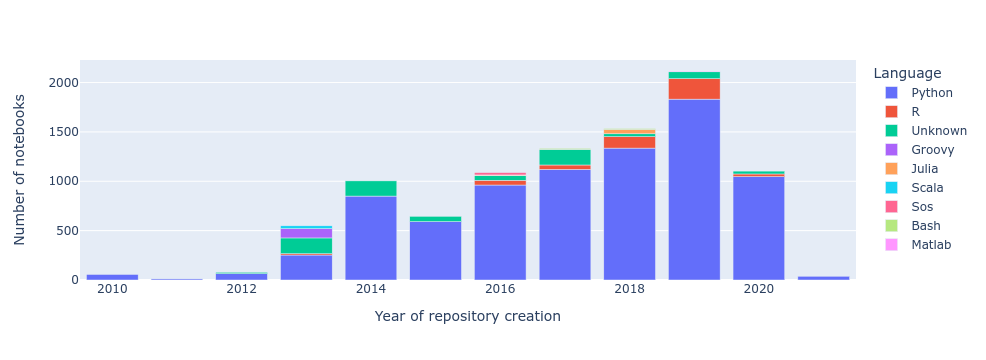

In [64]:
fig = px.bar(notebook_language_year_df, x='created_year', y='notebook_count', color='language',
            labels=dict(created_year="Year of repository creation", notebook_count="Number of notebooks", language="Language")
            )
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date')
fig.show()
filename = 'timeline_notebook_language_year'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Top Programming Languages in the notebooks

In [65]:
with connect() as session:
    query = (
        "select language "
        "from notebooks"
    )
    df = pd.read_sql(query, session.connection())

In [66]:
notebook_language_df = df['language'].value_counts().reset_index()
index_label = 'Programming language'
number_label = 'Number of notebooks'
notebook_language_df.columns = [index_label, number_label]
notebook_language_df[index_label] = notebook_language_df[index_label].str.capitalize()
notebook_language_df.head()

,Programming language,Number of notebooks
0,Python,8160
1,Unknown,720
2,R,461
3,Groovy,95
4,Julia,59


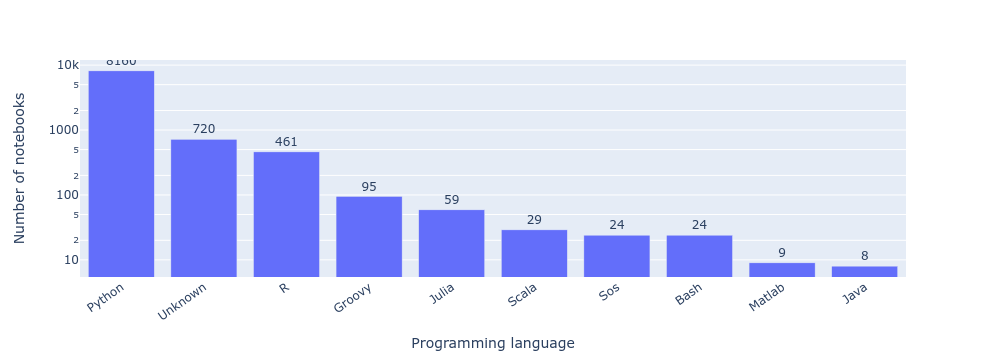

In [67]:
fig = px.bar(notebook_language_df.head(10), x=index_label, y=number_label)
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', yaxis_type = 'log', xaxis_tickangle=-35)
fig.show()
filename = 'top_notebook_language'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Python notebooks by minor and major Python version

In [68]:
with connect() as session:
    notebooks = pd.read_sql_table("notebooks", session.connection())

In [69]:
notebooks.loc[:,"minor_version"] = notebooks["language_version"].str[:3]
notebooks.loc[:,"major_version"] = notebooks["language_version"].str[:1]
python_notebooks = notebooks[notebooks.language == "python"]
# Removing inconsistencies
python_notebooks = python_notebooks[
    ~python_notebooks["language_version"].isin({"3", "1", "ES2015"})
]

In [70]:
python_major_version_df = python_notebooks["major_version"].value_counts().reset_index()
python_major_version_df.head()

,index,major_version
0,3,6028
1,2,1802
2,u,329


In [71]:
python_minor_version_df = python_notebooks["minor_version"].value_counts().reset_index().sort_values(by=['index'])
python_minor_version_df.head()

,index,minor_version
2,2.7,1802
6,3.4,174
3,3.5,930
0,3.6,2471
1,3.7,2031


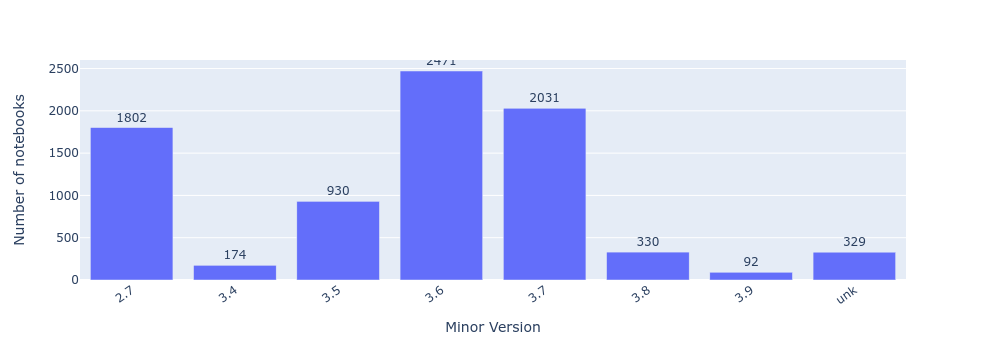

In [72]:
fig = px.bar(python_minor_version_df, x='index', y='minor_version')
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_title = 'Minor Version', 
                 yaxis_title = 'Number of notebooks')
fig.show()
filename = 'python_minor_version'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

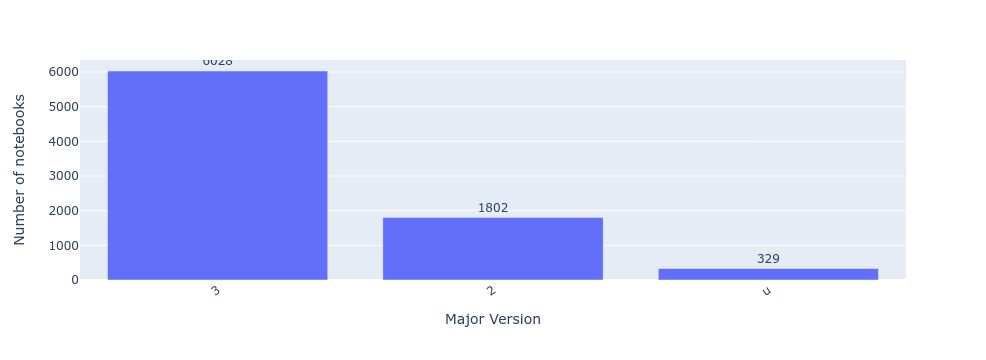

In [73]:
fig = px.bar(python_major_version_df, x='index', y='major_version')
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_title = 'Major Version', 
                 yaxis_title = 'Number of notebooks')
fig.show()
filename = 'python_major_version'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Python notebooks by major Python version by year of first commit

In [74]:
with connect() as session:
    query = (
        "select n.id,n.repository_id, n.name, n.language, n.language_version, n.nbformat, n.kernel, rd.created_at, rd.updated_at, rd.pushed_at "
        "from notebooks n, repository_data rd where n.repository_id=rd.repository_id"
    )
    notebooks = pd.read_sql(query, session.connection())    

In [75]:
notebooks.loc[:,"minor_version"] = notebooks["language_version"].str[:3]
notebooks.loc[:,"major_version"] = notebooks["language_version"].str[:1]
python_notebooks = notebooks[notebooks.language == "python"]
# Removing inconsistencies
python_notebooks = python_notebooks[
    ~python_notebooks["language_version"].isin({"3", "1", "ES2015"})
]

In [76]:
python_notebooks['created_year'] = pd.DatetimeIndex(python_notebooks['created_at']).strftime('%Y')

In [77]:
python_minor_version_df = python_notebooks[['created_year', 'minor_version',]].value_counts().reset_index().sort_values(by=['minor_version'])
python_minor_version_df.columns = ['Year of creation', 'Minor version','Number of notebooks']

In [78]:
python_minor_version_df = python_minor_version_df[python_minor_version_df['Year of creation'] > '2013']

In [79]:
python_major_version_df = python_notebooks[['created_year', 'major_version']].value_counts().reset_index()
python_major_version_df.columns = ['Year of creation', 'Major version','Number of notebooks']
python_major_version_df.head()

,Year of creation,Major version,Number of notebooks
0,2019,3,1699
1,2018,3,1149
2,2020,3,982
3,2017,3,818
4,2016,3,600


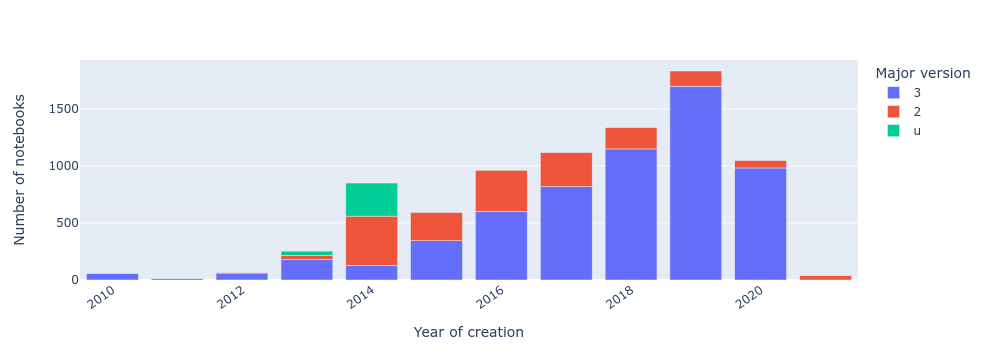

In [80]:
fig = px.bar(python_major_version_df, x='Year of creation', y='Number of notebooks', color='Major version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
filename = 'timeline_python_major_version_by_repo_creation'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Python notebooks by minor Python version by year of first commit

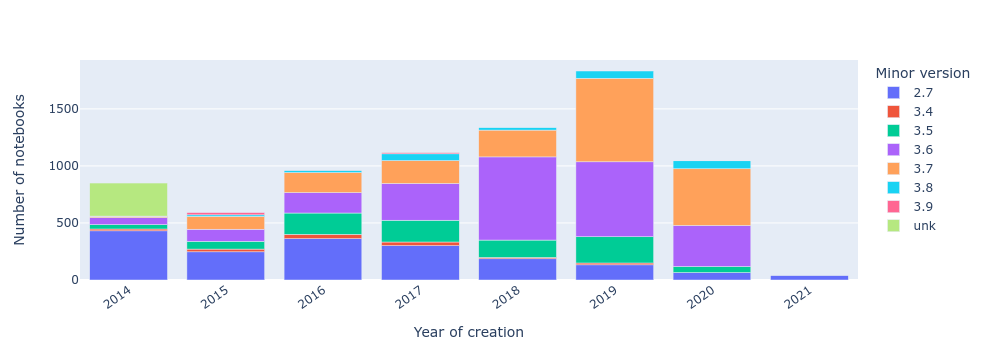

In [81]:
fig = px.bar(python_minor_version_df, x='Year of creation', y='Number of notebooks', color='Minor version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
filename = 'timeline_python_minor_version_by_repo_creation'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Python notebooks by minor Python version by year of last commit to the GitHub repository.

In [82]:
python_notebooks['updated_year'] = pd.DatetimeIndex(python_notebooks['updated_at']).strftime('%Y')

In [83]:
python_minor_version_df = python_notebooks[['updated_year', 'minor_version']].value_counts().reset_index().sort_values(by=['minor_version'])
python_minor_version_df.columns = ['Year of last update', 'Minor version','Number of notebooks']
python_minor_version_df = python_minor_version_df[python_minor_version_df['Year of last update'] > '2015']

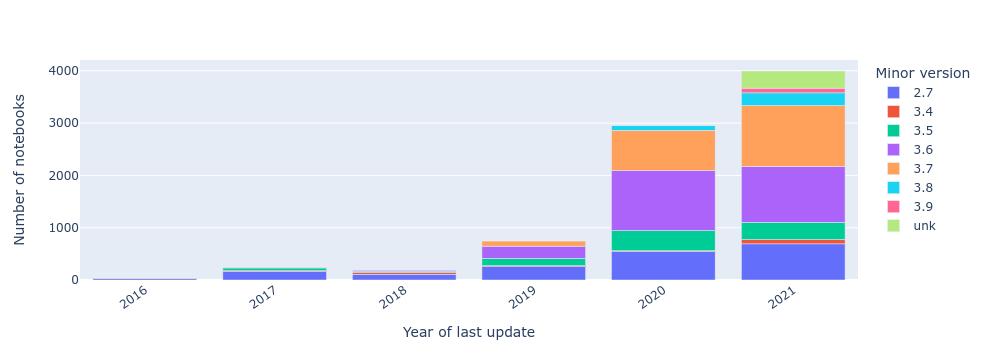

In [84]:
fig = px.bar(python_minor_version_df, x='Year of last update', y='Number of notebooks', color='Minor version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
filename = 'timeline_python_minor_version_by_repo_updation'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

## Frequent notebook code style errors as per the Python code style guide

In [85]:
with connect() as session:
    query = (
        "SELECT * "
        "from notebook_code_style"
    )
    nb_pycodestyle_errors = pd.read_sql(query, session.connection())

In [86]:
nb_pycodestyle_errors.head()

,id,cell_index,err_code,err_code_desc,notebook_id,repository_id
0,1,1,F404,from __future__ imports must occur at the begi...,18,12
1,2,1,E402,module level import not at top of file,18,12
2,3,1,E402,module level import not at top of file,18,12
3,4,1,E402,module level import not at top of file,18,12
4,5,1,F403,'from json2html import *' used; unable to dete...,18,12


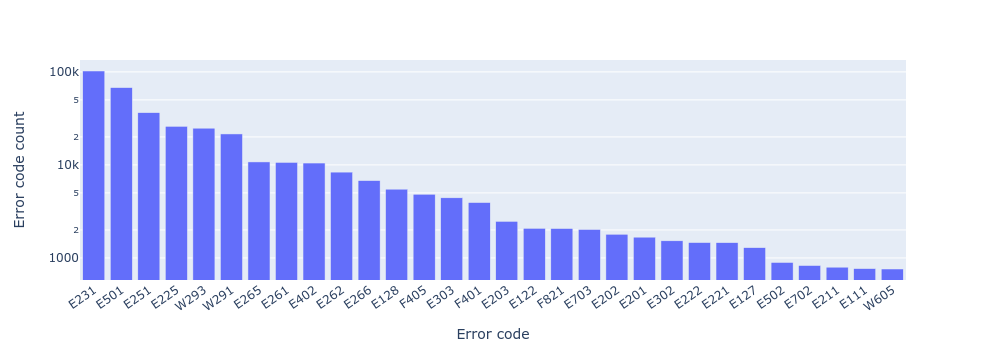

In [93]:
df = nb_pycodestyle_errors.groupby(['err_code'])['err_code_desc'].size().sort_values(ascending=False)
index_label = 'Error code'
number_label = 'Error code count'
df.columns = [index_label, number_label]
nb_pycodestyle_errors_df = pd.DataFrame({'Error code':df.index, 'Error code count':df.values})

fig = px.bar(nb_pycodestyle_errors_df.head(30), x=index_label, y=number_label)
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_title = index_label, 
                 yaxis_title = number_label, yaxis_type = 'log')
fig.show()
filename = 'nb_pycodestyle_errors'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)